In [1990]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

#import DL libs
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

plt.style.use('fivethirtyeight')


plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

%matplotlib inline


In [1991]:
# util function
def plot_distributions(X):
    """
    plots distribution of numerical data from dataframe
    """
    X = pd.melt(X)
    g = sns.FacetGrid(X, col="variable",  col_wrap=3, sharex=False, sharey=False)
    g = g.map(sns.distplot, "value")
    
def plot_missing_values(X):
    """
    plots missing values per column of  dataframe in a bar chart 
    """
    missing = X.isnull().sum()
    missing = missing[missing>0]
    missing.sort_values(inplace=True)
    missing.plot.bar()
    
def spearman(frame, features=[], target='y'):
    """
    plots spearman correlation of each features with target
    """
    spr = pd.DataFrame()
    print(features)
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame[target], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
    
def plot_corr_heatmap(X, title="Corr Heatmap"):
    X_corr = X.corr()
    plt.figure(figsize=(20,7))
    # Add title
    plt.title(title)
    mask = np.zeros_like(X_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(mask=mask, data=X_corr, annot=True, cmap=cmap)
    
def pairplot_with_target(X, features, target):
    def pairplot(x, y, **kwargs):
        ax = plt.gca()
        ts = pd.DataFrame({'time': x, 'val': y})
        ts = ts.groupby('time').mean()
        ts.plot(ax=ax)
        plt.xticks(rotation=90)

    f = pd.melt(X, id_vars=[target], value_vars=features)
    g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
    g = g.map(pairplot, "value", target)

## PART 1

### 1)

In [1992]:
#read datasets
btc_price = pd.read_csv('../data/BTCPrice.csv', index_col=['Date'])
btc_price.columns = ['PRICE']

btc_trd_vol = pd.read_csv('../data/BTCTradeVolume.csv', index_col=['Date'])
btc_trd_vol.columns = [ 'TRD_VOLUME']

btc_miner_fees =  pd.read_csv('../data/BTCtransaction-fees.csv', index_col=['Date'])
btc_miner_fees.columns = ['MINERS_FEE']


btc_transaction_vol = pd.read_csv('../data/BTCTransactionVolume.csv', index_col=['Date'])
btc_transaction_vol.columns = ['TRAN_VOL']

btc_price_vol = pd.read_csv('../data/BTCprice-volatility.csv', index_col=['Date'])
btc_price_vol.columns = ['PRICE_VOL']

btc_miner_revenue =  pd.read_csv('../data/BTCminer-revenue.csv', index_col=['Date'])
btc_miner_revenue.columns = ['MINERS_REVENUE']

btc_difficulty = pd.read_csv('../data/BTCDifficulty.csv', index_col=['Date'])
btc_difficulty.columns = ['DIFFICULTY']

btc_transaction_per_block = pd.read_csv('../data/BTCTransactionPerBlock.csv', index_col=['Date'])
btc_transaction_per_block.columns = ['TRAN_BLOCK']

btc_hash_rate = pd.read_csv('../data/BTChash-rate.csv', index_col=['Date'])
btc_hash_rate.columns = ['HASH_RATE'] 

btc_market_cap = pd.read_csv('../data/BTCmarket-cap.csv', index_col=['Date'])
btc_market_cap.columns = ['MARKET_CAP'] 

bch_price =  pd.read_csv('../data/BCHprice.csv', index_col=['Date'])
bch_price.columns = ['BCH_PRICE']

btc_money_supply =  pd.read_csv('../data/BTCmoney-supply.csv', index_col=['Date'])
btc_money_supply.columns = ['MONEY_SUPPLY']



btc_data = pd.concat([btc_price, btc_trd_vol, btc_miner_fees, btc_transaction_vol, btc_price_vol,
                     btc_miner_revenue, btc_difficulty, btc_transaction_per_block, btc_hash_rate,
                     btc_money_supply, bch_price, btc_market_cap], axis=1, sort=True)
btc_data.index= pd.to_datetime(btc_data.index, format='%Y-%m-%d')
btc_data = btc_data.loc[(btc_data.index >= '2010-01-01') & (btc_data.index <= '2019-06-30')]

In [1993]:
engineered_features = ['ma7', '14sd']
btc_data['ma7'] = btc_data['PRICE'].rolling(7).mean()
btc_data['14sd'] = btc_data['PRICE'].rolling(14).std()
base_features = list(btc_data.columns)

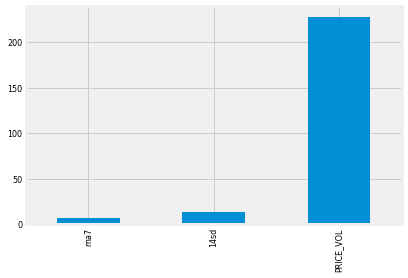

In [1994]:
plot_missing_values(btc_data)



0 price does not make sense in the beginning of 2010. Its probably due to the lack of trading on exchanges at that time. It would be best to drop rows with 0 price or 0 trade volume. Since prices with 0 trading volume are also not reliable. Removing 0 price value also takes care of the missing value in the above columns.


In [1995]:
btc_data = btc_data.drop(btc_data[btc_data['PRICE']==0].index)

In [1996]:
btc_data.describe()

PRICE    TRD_VOLUME   MINERS_FEE      TRAN_VOL    PRICE_VOL  \
count   3240.000000  3.240000e+03  3240.000000  3.240000e+03  3240.000000   
mean    1784.235752  1.291471e+08    61.613730  2.034392e+05    76.235959   
std     3097.652417  3.324501e+08   111.997930  2.528356e+05    50.449536   
min        0.060900  5.131510e+01     0.000000  6.221000e+03     0.000000   
25%       13.712525  6.742530e+05    12.662478  1.073318e+05    39.107889   
50%      385.080000  7.818132e+06    24.843805  1.719355e+05    64.459420   
75%     1230.232719  8.482045e+07    52.676742  2.522833e+05    99.656925   
max    19498.683333  5.352016e+09  1495.748916  5.825066e+06   272.447767   

       MINERS_REVENUE    DIFFICULTY   TRAN_BLOCK     HASH_RATE  MONEY_SUPPLY  \
count     3240.000000  3.240000e+03  3240.000000  3.240000e+03  3.240000e+03   
mean      4399.985644  1.041392e+12   883.314062  7.608236e+06  1.287301e+07   
std       2519.248731  2.101884e+12   765.905471  1.525644e+07  3.899653e+06   
min       1242.089114  5.120000e+02     1.000000  3.970459e-03  3.739600e+06   
25%       2166.924622  3.054628e+06   224.000000  2.176505e+01  1.031562e+07   
50%       3830.998224  4.127287e+10   632.500000  3.110143e+05  1.375114e+07   
75%       5903.135531  4.996359e+11  1536.395369  3.697014e+06  1.626728e+07   
max      15371.520742  7.934713e+12  2762.540984  6.219192e+07  1.778861e+07   

         BCH_PRICE    MARKET_CAP           ma7         14sd  
count  3240.000000  3.240000e+03   3240.000000  3240.000000  
mean    436.786290  2.977832e+10   1773.277805   118.838675  
std     538.467441  5.268743e+10   3076.141552   288.304513  
min       0.060000  2.308860e+05      0.010986     0.000473  
25%      13.440000  1.240693e+08     13.619407     1.091907  
50%     287.605000  5.440071e+09    382.347143    12.338536  
75%     606.700000  1.996838e+10   1204.589130    68.669680  
max    3810.470000  3.214197e+11  18106.656476  2668.099182

### 2)

Text(0.5, 0, 'date')

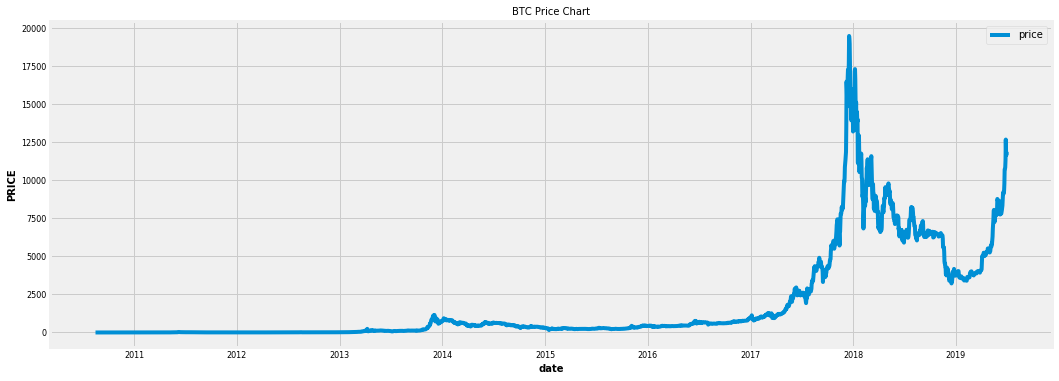

In [1997]:
plt.figure(figsize=(16,6))
plt.title('BTC Price Chart')
sns.lineplot(btc_data.index, btc_data['PRICE'], label='price')
plt.xlabel('date')


### 2 & 3)

In [1998]:
#feature engineering
# lets split our data set before we do analysis on data set to make testing phase completely independent
target = 'PRICE'
train_mask = (btc_data.index >= '2010-01-01') & (btc_data.index <= '2018-06-30')
valid_mask = (btc_data.index >= '2018-07-01') & (btc_data.index <= '2018-12-31')
test_mask = (btc_data.index >= '2019-01-01') & (btc_data.index <= '2019-06-30')

X_train_act =  btc_data.loc[train_mask][base_features]
y_train_act =  pd.DataFrame(btc_data.loc[train_mask][target])

X_valid_act =  pd.DataFrame(btc_data.loc[valid_mask][base_features])
y_valid_act = pd.DataFrame(btc_data.loc[valid_mask][target])

X_test_act =  btc_data.loc[test_mask][base_features]
y_test_act =  pd.DataFrame(btc_data.loc[test_mask][target])

missing = X_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)

In [1999]:

#using constant imputer for price volatility and standard scaler for normalization
constant_imputer = SimpleImputer(strategy='constant')

#normalizer
normalizer = StandardScaler()
y_normalizer = StandardScaler()

def preprocessing_pipeline(X, train=False):
    ind = X.index
    # Here we only scale the train dataset for fitting normalizer to prevent data leakage
    if  train:
        X = pd.DataFrame(constant_imputer.fit_transform(X), columns=base_features)
        X = pd.DataFrame(normalizer.fit_transform(X), columns=base_features)
    else:
        X = pd.DataFrame(constant_imputer.transform(X), columns=base_features)
        
        X = pd.DataFrame(normalizer.transform(X), columns=base_features)
    X.index = ind
    return X
        
def y_preprocessing_pipeline(y, train=False):
    ind = y.index
    if  train:
        y = pd.DataFrame(y_normalizer.fit_transform(y), columns=[target])
    else: 
        y = pd.DataFrame(y_normalizer.transform(y), columns=[target])
    y.index = ind
    return y



In [2000]:
X_train = preprocessing_pipeline(X_train_act, train=True)
X_valid = preprocessing_pipeline(X_valid_act, train=False)
X_test = preprocessing_pipeline(X_test_act, train=False)

y_train = y_preprocessing_pipeline(y_train_act, train=True)
y_valid = y_preprocessing_pipeline(y_valid_act, train=False)
y_test = y_preprocessing_pipeline(y_test_act, train=False)

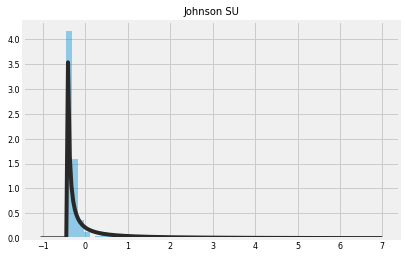

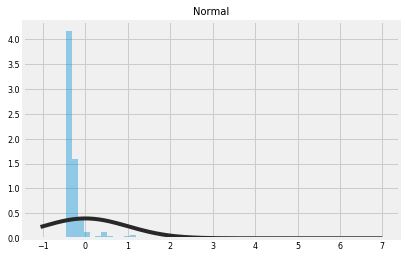

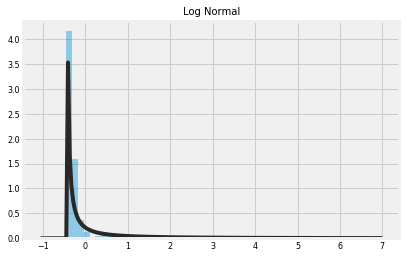

In [2001]:
import scipy.stats as st
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y_train, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y_train, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y_train, kde=False, fit=st.lognorm)

/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


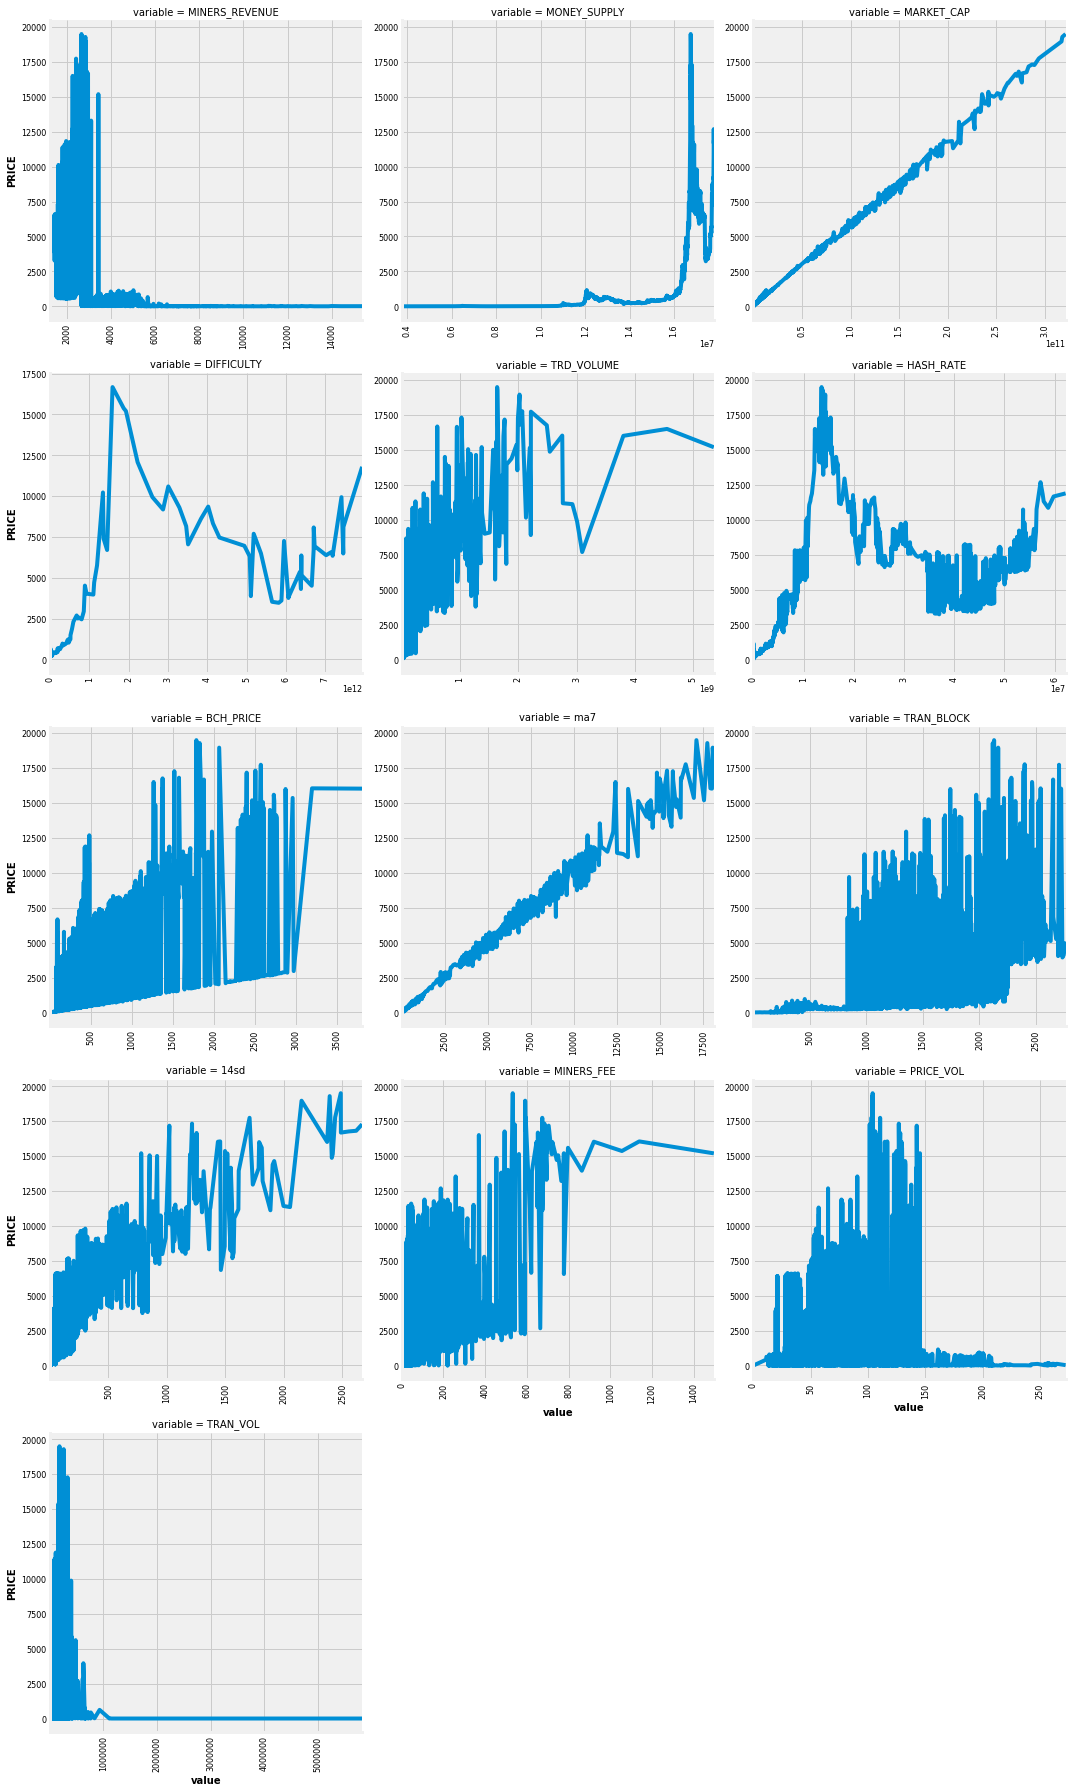

In [2002]:
pairplot_with_target(btc_data, list(set(base_features) - set(['PRICE'])), 'PRICE')

We can see some linear relationship of target variable with features

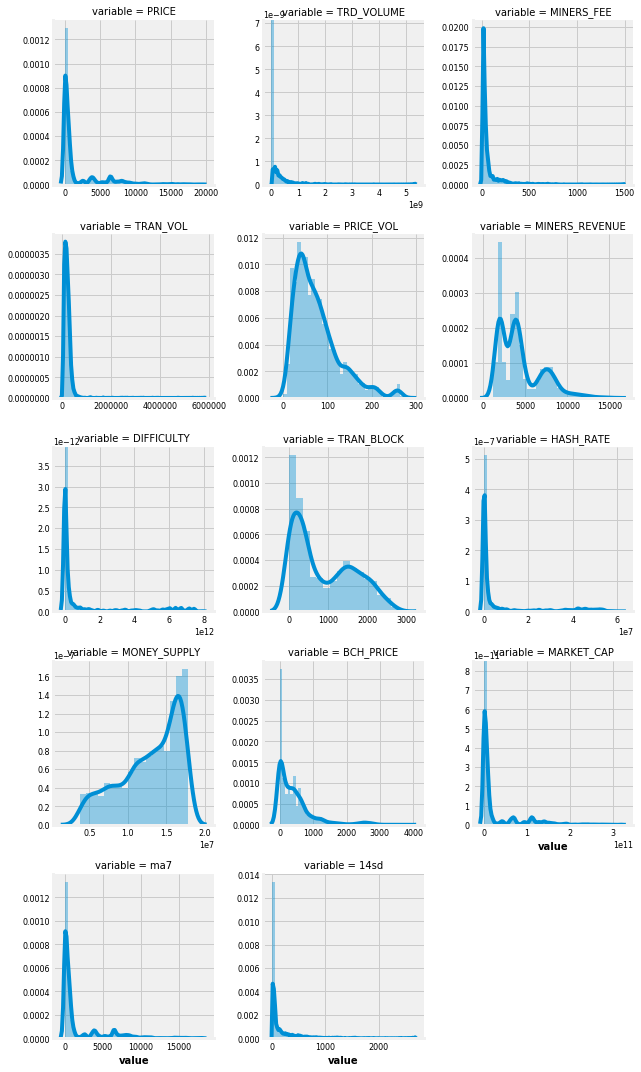

In [2003]:
plot_distributions(btc_data)

Prices, price_vol, hash_rate, TRAN_VOL appear to be following lognormal distribution. We can make log transformation to make distributions bit symmetrical

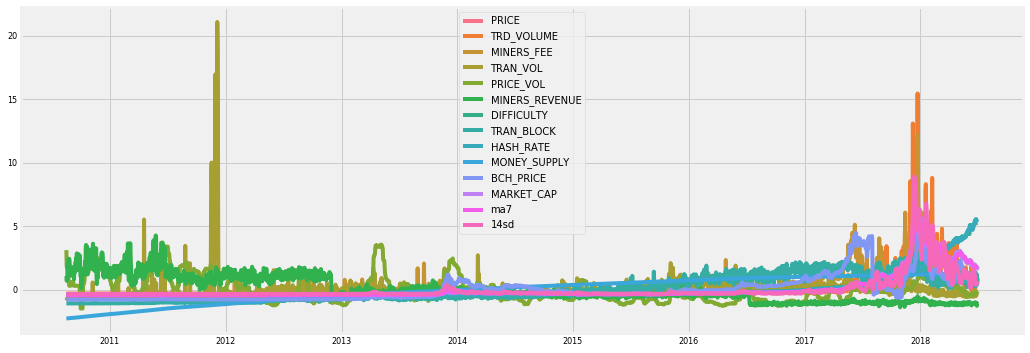

In [2004]:
#plot all columns in same chart 
plt.figure(figsize=(16,6))

sns.lineplot(data=X_train, dashes=False)

### 4)

PRICE  TRD_VOLUME  MINERS_FEE  TRAN_VOL  PRICE_VOL  \
PRICE           1.000000    0.854427    0.628143 -0.013784   0.110893   
TRD_VOLUME      0.854427    1.000000    0.631983  0.017290   0.127128   
MINERS_FEE      0.628143    0.631983    1.000000  0.089208   0.014377   
TRAN_VOL       -0.013784    0.017290    0.089208  1.000000  -0.038710   
PRICE_VOL       0.110893    0.127128    0.014377 -0.038710   1.000000   
MINERS_REVENUE -0.412486   -0.296069   -0.386593 -0.086158   0.418934   
DIFFICULTY      0.811061    0.600732    0.298670 -0.041675   0.043356   
TRAN_BLOCK      0.531868    0.442263    0.646756  0.135970  -0.314976   
HASH_RATE       0.815741    0.605587    0.300511 -0.041525   0.045488   
MONEY_SUPPLY    0.483307    0.360243    0.446384  0.115920  -0.436119   
BCH_PRICE       0.643371    0.511928    0.729353  0.048378  -0.047536   
MARKET_CAP      0.999648    0.851829    0.621272 -0.013741   0.110489   
ma7             0.995929    0.856783    0.632284 -0.015068   0.112108   
14sd            0.912814    0.880236    0.626682 -0.000733   0.155599   

                MINERS_REVENUE  DIFFICULTY  TRAN_BLOCK  HASH_RATE  \
PRICE                -0.412486    0.811061    0.531868   0.815741   
TRD_VOLUME           -0.296069    0.600732    0.442263   0.605587   
MINERS_FEE           -0.386593    0.298670    0.646756   0.300511   
TRAN_VOL             -0.086158   -0.041675    0.135970  -0.041525   
PRICE_VOL             0.418934    0.043356   -0.314976   0.045488   
MINERS_REVENUE        1.000000   -0.409704   -0.754873  -0.407848   
DIFFICULTY           -0.409704    1.000000    0.439714   0.998796   
TRAN_BLOCK           -0.754873    0.439714    1.000000   0.437955   
HASH_RATE            -0.407848    0.998796    0.437955   1.000000   
MONEY_SUPPLY         -0.902853    0.468587    0.852471   0.467762   
BCH_PRICE            -0.592617    0.502924    0.710018   0.504788   
MARKET_CAP           -0.408425    0.819130    0.529818   0.823734   
ma7                  -0.411962    0.819398    0.526475   0.823691   
14sd                 -0.312381    0.627728    0.435275   0.636776   

                MONEY_SUPPLY  BCH_PRICE  MARKET_CAP       ma7      14sd  
PRICE               0.483307   0.643371    0.999648  0.995929  0.912814  
TRD_VOLUME          0.360243   0.511928    0.851829  0.856783  0.880236  
MINERS_FEE          0.446384   0.729353    0.621272  0.632284  0.626682  
TRAN_VOL            0.115920   0.048378   -0.013741 -0.015068 -0.000733  
PRICE_VOL          -0.436119  -0.047536    0.110489  0.112108  0.155599  
MINERS_REVENUE     -0.902853  -0.592617   -0.408425 -0.411962 -0.312381  
DIFFICULTY          0.468587   0.502924    0.819130  0.819398  0.627728  
TRAN_BLOCK          0.852471   0.710018    0.529818  0.526475  0.435275  
HASH_RATE           0.467762   0.504788    0.823734  0.823691  0.636776  
MONEY_SUPPLY        1.000000   0.657277    0.479434  0.483101  0.376030  
BCH_PRICE           0.657277   1.000000    0.637672  0.646909  0.556733  
MARKET_CAP          0.479434   0.637672    1.000000  0.995749  0.910282  
ma7                 0.483101   0.646909    0.995749  1.000000  0.909892  
14sd                0.376030   0.556733    0.910282  0.909892  1.000000

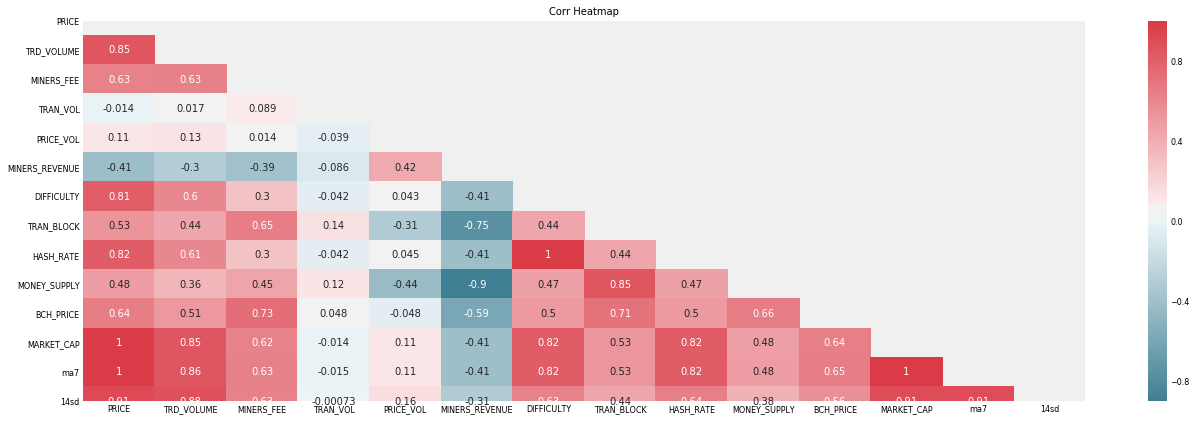

In [2005]:
plot_corr_heatmap(X_train)
X_train.corr()

/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


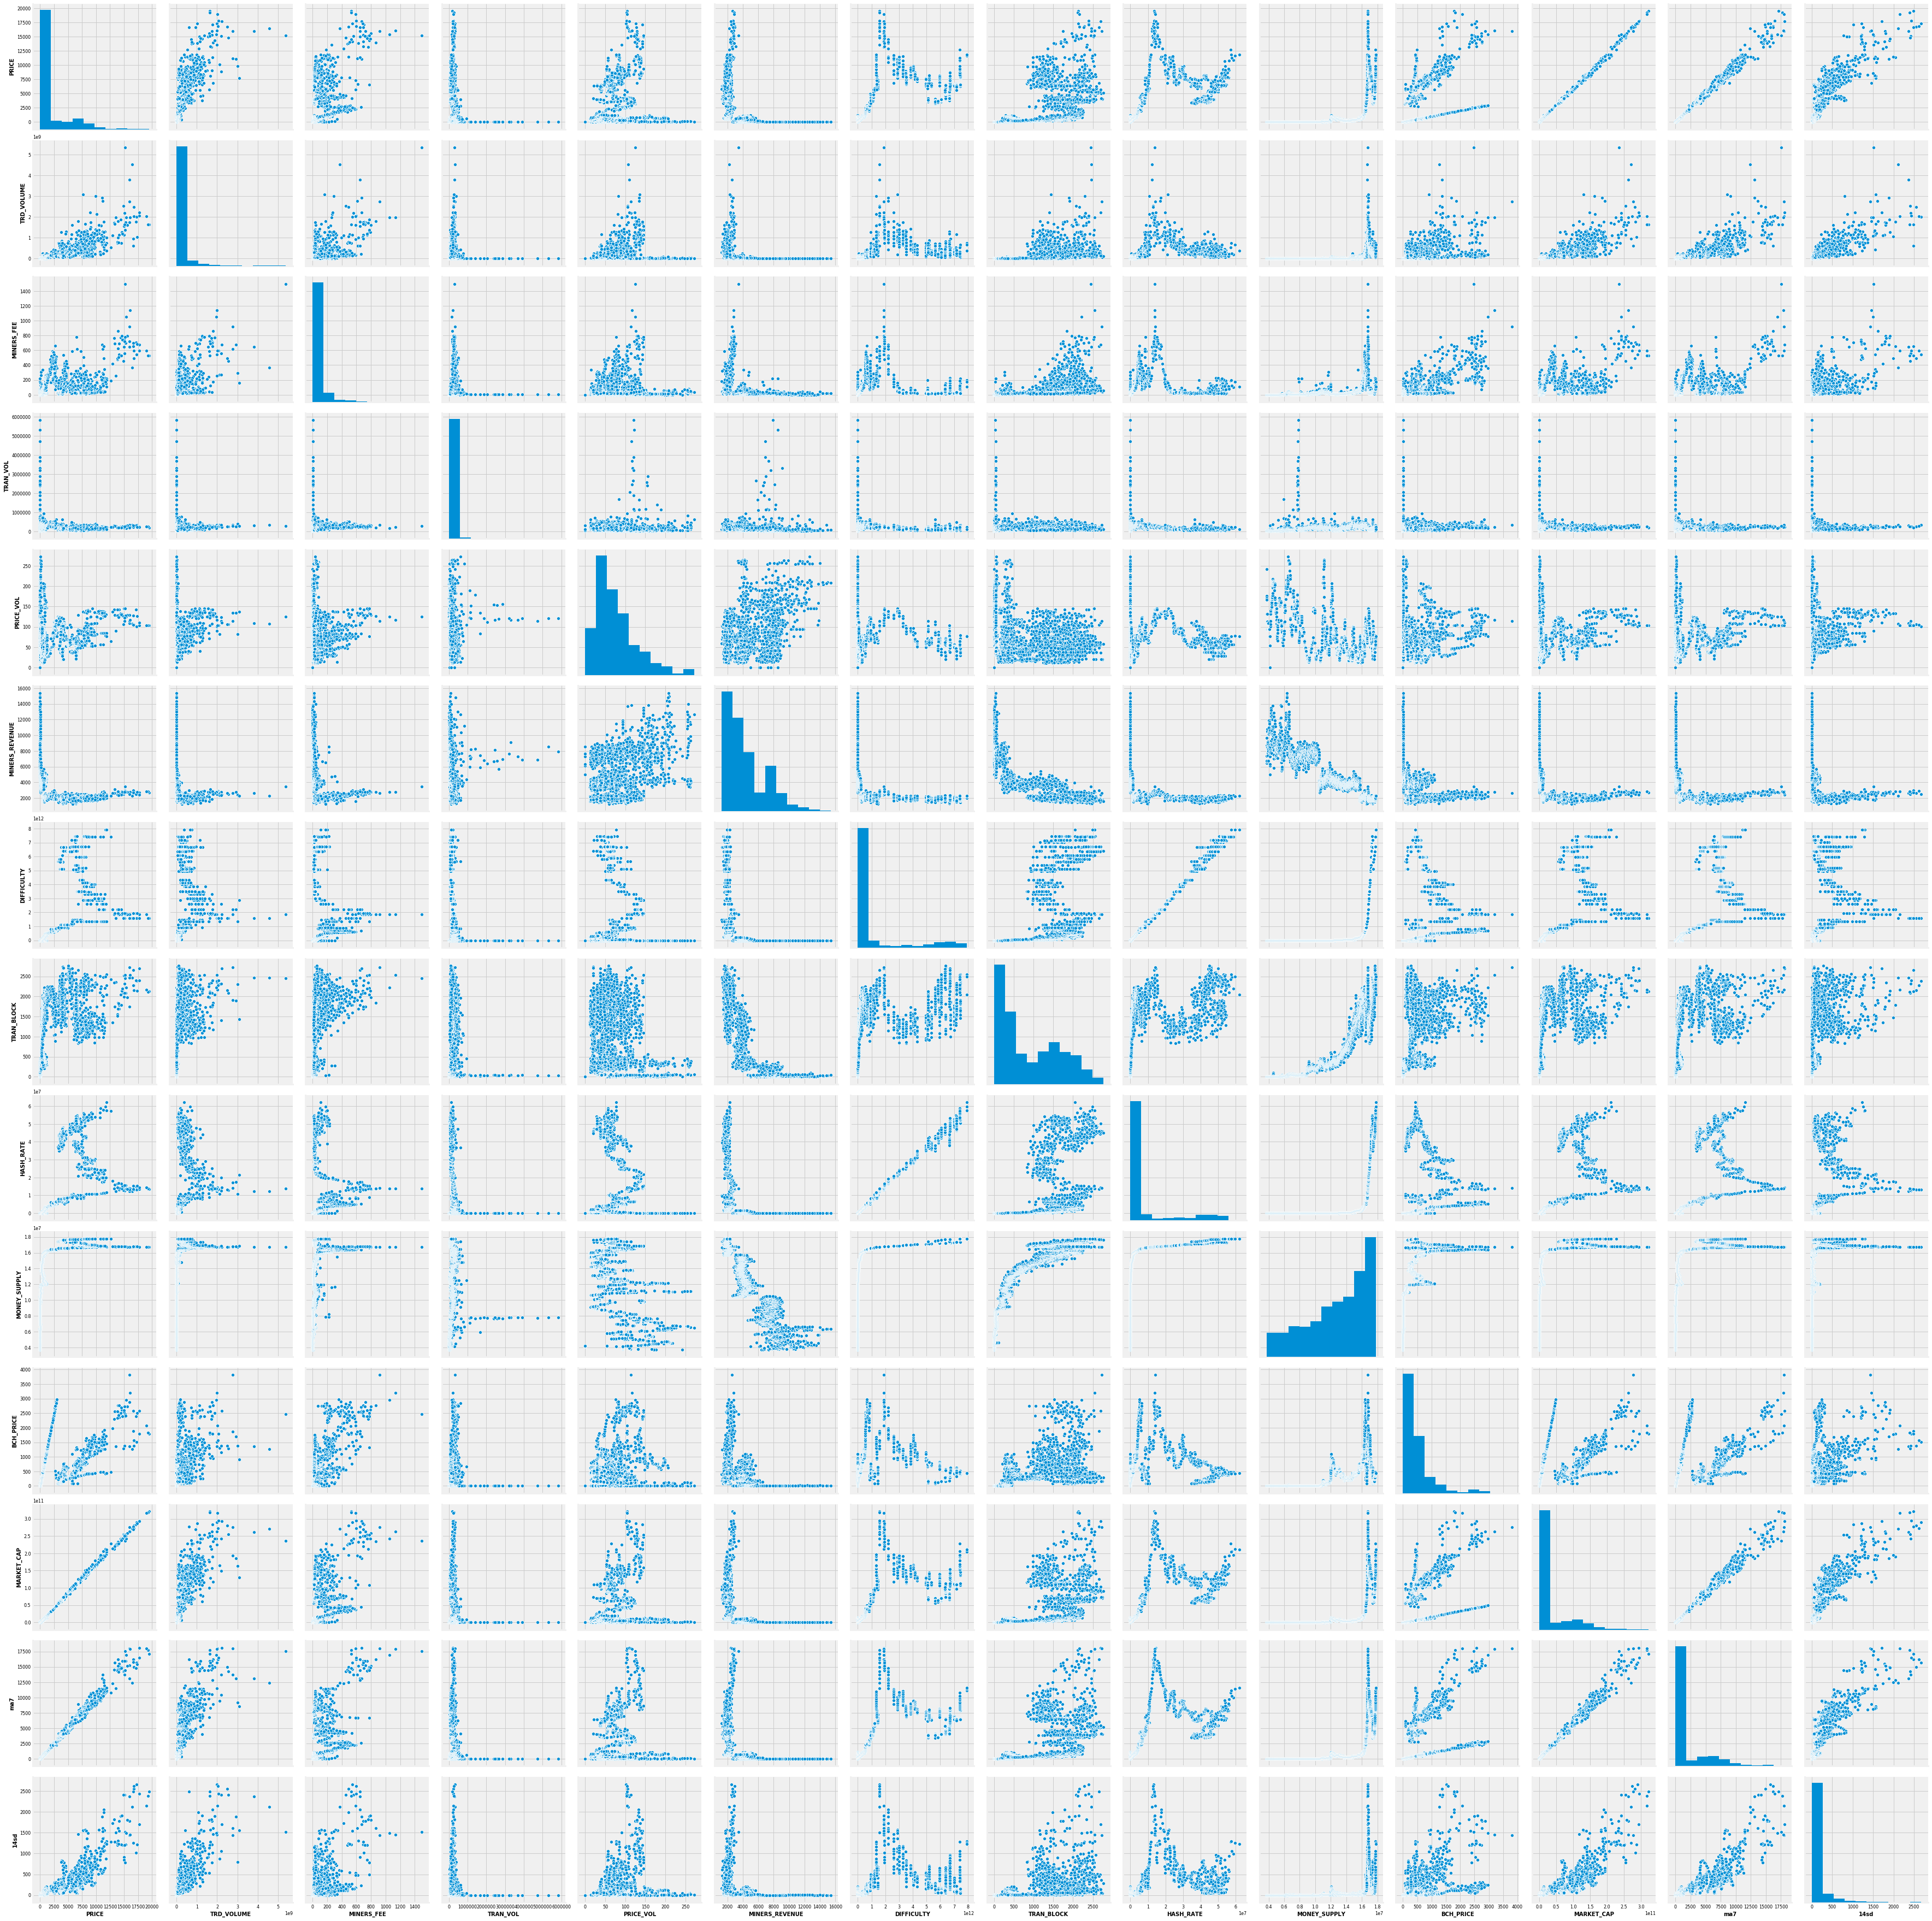

In [2006]:
## pair plot of all variable with each other and target
sns.pairplot(btc_data, size = 3.5)

highly correlated

1)Money supply and transections per block 

2)BCH price and transections per block 

4) hashrate and difficulty are almost perfectly correlated(we should drop one of thesse)

5) miners fee and bch price

6) transections per block and bch price

Negatively corr

1) Miners revenue and transections per block 

2) Miners revenue and money supply(number of bitcoins)


We should drop difficulty as it is highly correlated with hashrate and trd volume.


In [2007]:
X_train = X_train.drop(['DIFFICULTY'], axis=1)
X_test = X_test.drop(['DIFFICULTY'], axis=1)
X_valid = X_valid.drop(['DIFFICULTY'], axis=1)
base_features = list(set(base_features )- set(['DIFFICULTY']))

### Observations

1) We have missing values for price volatility

2) Std dev of most of the columns is pretty high since 2010

3) We should reduce highly correlated features (this can be done using greedy algorithms or relying on L1 regularization of NNs)

4) Standardised features are not stationary which is evident from high shocks(non constant volatility) in the time series plot.



## Part 2

Basic Pre processing and split done in sub parts 2,3 of Part 1.

Now, lets do feature engineering to derive more predictors from past 28 days.
First lets concat features from last 28 days and also create 


In [2008]:
#### data processing Utils
def create_lagged_features(X,features, lag=3, dropna=False):
    """
    This function creates the lagged feature dataframe specifically useful for time series modelling
    """
    c_X = X
    lagged_dfs = [ c_X.shift(i).add_suffix('_' + str(i)) for i in range(lag)]
    lagged_dfs = pd.concat(lagged_dfs, axis=1)
    if dropna:
        lagged_dfs = lagged_dfs.dropna()
    return lagged_dfs

def create_leading_targets(X, lead=3, dropna=False):
    """
    This function creates leading targets specifically useful for predicting over multiple periods
    """
    leading_df = [ X.shift(-i).add_suffix('_' + str(i)) for i in range(1, lead+1)]
    leading_df =pd.concat(leading_df, axis=1)
    if dropna:
        leading_df = leading_df.dropna()
    return leading_df

In [2009]:
lag = 28

In [2010]:
X_train_lagged = create_lagged_features(X_train, base_features,lag=lag)[lag:-7]
y_train_leading = create_leading_targets(pd.DataFrame(y_train), lead=7)[lag:-7]

X_valid_lagged = create_lagged_features(X_valid, base_features,lag=lag)[lag:-7]
y_valid_leading = create_leading_targets(pd.DataFrame(y_valid), lead=7)[lag:-7]


X_test_lagged = create_lagged_features(X_test, base_features, lag=lag)[lag:-7]
y_test_leading = create_leading_targets(pd.DataFrame(y_test), lead=7)[lag:-7]

we will start trading after 28 days and also stop trading 7 days before to avoid handling NaN cases 

Lets verify wheather input features are based on 28 days look back period and targets on next periods

On 2018-06-19, we are using the prices and features from past 28 days to predict next 7 days prices. PRICE_1 is next day price and price 0 is the current day price.

## Part 3

Now that our data sets are ready lets start training.

But before that lets create score function

In [2011]:
def get_model_score(model, X, y_true):
    y_pred = model.predict(X)
    unnormalized_pred = pd.DataFrame(y_normalizer.inverse_transform(y_pred))
    unnormalized_true = pd.DataFrame(y_normalizer.inverse_transform(y_true))
    return mean_absolute_error(unnormalized_pred, unnormalized_true)


### 1) Average and Last Value model

avg benchmark score:  537.2840142097441
last val benchmark score:  309.17370001833166


Text(0.5, 0, 'date')

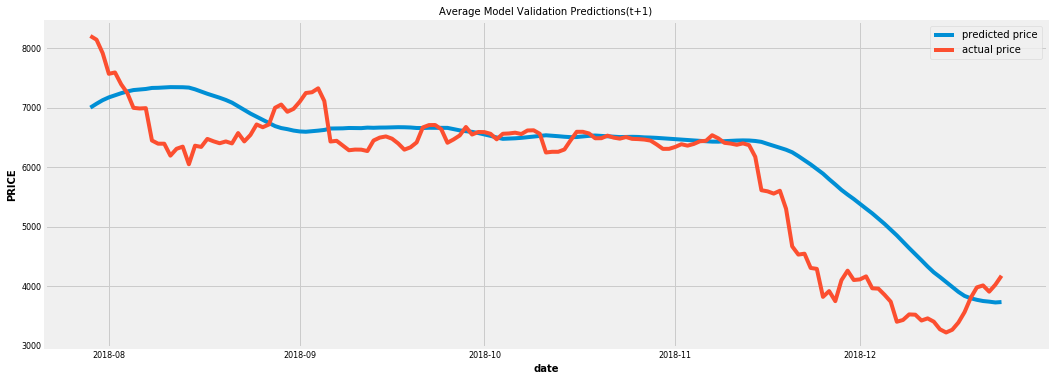

In [2012]:
def get_avg_model_preds(data, target):
    y_preds = btc_data[target].rolling(28).mean().loc[y_valid_leading.index]
    return pd.concat([y_preds]*7, axis=1) 

def get_last_val_preds(data, target):
    y_preds = data[target].shift(1).loc[y_valid_leading.index]
    return pd.concat([y_preds]*7, axis=1) 

last_val_preds = get_last_val_preds(btc_data, target)
avg_model_preds = get_avg_model_preds(btc_data, target)
unnorm_y_valid = y_normalizer.inverse_transform(y_valid_leading)
print("avg benchmark score: ", mean_absolute_error(unnorm_y_valid, avg_model_preds))
print("last val benchmark score: ", mean_absolute_error(unnorm_y_valid, last_val_preds))


plt.figure(figsize=(16,6))
plt.title('Average Model Validation Predictions(t+1)')
sns.lineplot(y_valid_leading.index, avg_model_preds.iloc[:,0], label='predicted price')
sns.lineplot(y_valid_leading.index, unnorm_y_valid[:, 0], label='actual price')
plt.xlabel('date')



Text(0.5, 0, 'date')

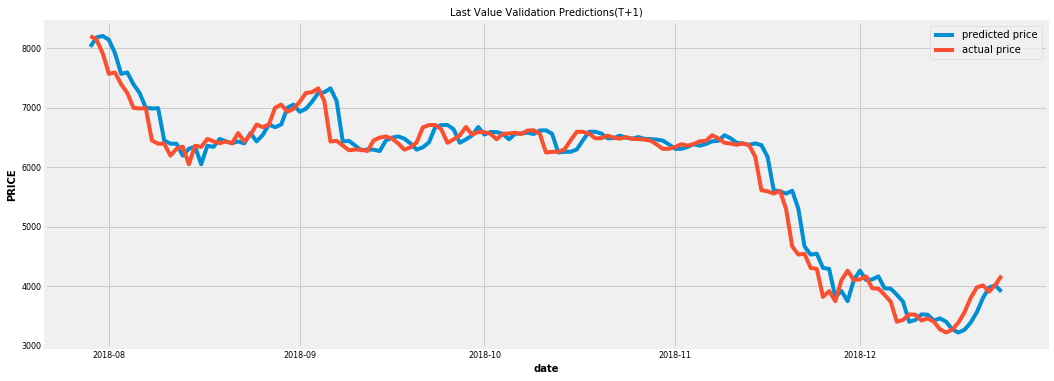

In [2013]:
plt.figure(figsize=(16,6))
plt.title('Last Value Validation Predictions(T+1)')
sns.lineplot(y_valid_leading.index, last_val_preds.iloc[:,0], label='predicted price')
sns.lineplot(y_valid_leading.index, unnorm_y_valid[:, 0], label='actual price')

plt.xlabel('date')


### 2)  simple neural network 

## Tune N (look back period)

In [2014]:
from tensorflow import set_random_seed
from keras.regularizers import l1

set_random_seed(2)
# imp_features = ['PRICE_0', 'PRICE_1', 'PRICE_2', 'PRICE_3', 'PRICE_4', 'PRICE_5', 'PRICE_6', 'PRICE_7',
#                 'HASH_RATE_0','MINERS_REVENUE_0',
#                 'ma7_0', '14sd_0']
# X_train_lagged_new = X_train_lagged[imp_features]
# X_valid_lagged_new = X_valid_lagged[imp_features]

scores = {'N': [],
          'mae': []}
def train_simple_nn(X_train, y_train, X_valid, y_valid, lag=28, epochs=10, batch_size=50):
    X_train_lagged = create_lagged_features(X_train, base_features,lag=lag)[lag:-7]
    y_train_leading = create_leading_targets(pd.DataFrame(y_train), lead=7)[lag:-7]
    X_valid_lagged = create_lagged_features(X_valid, base_features,lag=lag)[lag:-7]
    y_valid_leading = create_leading_targets(pd.DataFrame(y_valid), lead=7)[lag:-7]
    simple_nn = Sequential()
    simple_nn.add(Dense(50, input_dim=X_train_lagged.shape[1], activation='relu'))
    simple_nn.add(Dense(50, activation='relu'))
    simple_nn.add(Dense(7))
    simple_nn.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
    h = simple_nn.fit(X_train_lagged, y_train_leading, verbose=0,
                      epochs=epochs, batch_size=batch_size)
    curr_score = get_model_score(simple_nn, X_valid_lagged, y_valid_leading)
    return curr_score
    
    
n = range(3, 28, 3)
for i in n:
    curr_score = train_simple_nn(X_train, y_train, X_valid, y_valid, lag=i, epochs=10, batch_size=50)  
    scores['N'].append(i)
    scores['mae'].append(curr_score)

In [2015]:
pd.DataFrame(scores)

N          mae
0   3   651.666116
1   6   883.221157
2   9   992.218222
3  12  1389.863329
4  15  1117.797892
5  18  1429.316838
6  21  2286.232648
7  24  1629.199165
8  27  2653.994379

## Tuning epoch and batch size

In [2017]:
epochs = range(10, 100, 20)
batch = range(20, 200, 30)
scores = {'epoch': [],
          'batch': [],
          'mae': []}
for e in epochs:
    for b in batch:
        print(e, b)
        curr_score = train_simple_nn(X_train, y_train, X_valid, y_valid, lag=6, epochs=e, batch_size=b)  
        scores['epoch'].append(e)
        scores['batch'].append(b)
        scores['mae'].append(curr_score)
        

10 20
10 50
10 80
10 110
10 140
10 170
30 20
30 50
30 80
30 110
30 140
30 170
50 20
50 50
50 80
50 110
50 140
50 170
70 20
70 50
70 80
70 110
70 140
70 170
90 20
90 50
90 80
90 110
90 140
90 170


In [2018]:
pd.DataFrame(scores)

epoch  batch          mae
0      10     20  1014.098793
1      10     50   640.606369
2      10     80   727.887979
3      10    110   822.998889
4      10    140  1073.494148
5      10    170  1091.049258
6      30     20   843.265795
7      30     50   733.880562
8      30     80  1235.231638
9      30    110  1143.976713
10     30    140   798.295135
11     30    170   684.959226
12     50     20   636.086769
13     50     50   888.947756
14     50     80   939.196168
15     50    110   662.135977
16     50    140   835.490247
17     50    170   923.726415
18     70     20   938.482419
19     70     50   769.443541
20     70     80  1118.878887
21     70    110   842.294044
22     70    140   854.628821
23     70    170   999.235724
24     90     20   621.863783
25     90     50   663.074320
26     90     80   752.007501
27     90    110  1658.121609
28     90    140   948.230623
29     90    170   927.212660

### Final tuned model
N = 6

e = 50

batch_size = 20

In [2033]:
lag=6

X_train_lagged = create_lagged_features(X_train, base_features,lag=lag)[lag:-7]
y_train_leading = create_leading_targets(pd.DataFrame(y_train), lead=7)[lag:-7]

X_valid_lagged = create_lagged_features(X_valid, base_features,lag=lag)[lag:-7]
y_valid_leading = create_leading_targets(pd.DataFrame(y_valid), lead=7)[lag:-7]

In [2034]:
X_test_lagged = create_lagged_features(X_test, base_features, lag=lag)[lag:-7]
y_test_leading = create_leading_targets(pd.DataFrame(y_test), lead=7)[lag:-7]
simple_nn = Sequential()
simple_nn.add(Dense(50, input_dim=X_train_lagged.shape[1], activation='relu'))
simple_nn.add(Dense(50, activation='relu'))
simple_nn.add(Dense(7))
simple_nn.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
h = simple_nn.fit(X_train_lagged, y_train_leading, epochs=50, batch_size=20,
                  validation_data=(X_valid_lagged, y_valid_leading), shuffle=False)

Train on 2862 samples, validate on 171 samples
Epoch 1/50
2862/2862 [==============================] - 28s 10ms/step - loss: 0.2509 - acc: 0.1674 - val_loss: 0.6591 - val_acc: 0.1871
Epoch 2/50
2862/2862 [==============================] - 3s 1ms/step - loss: 0.2007 - acc: 0.1443 - val_loss: 0.5598 - val_acc: 0.3041
Epoch 3/50
2862/2862 [==============================] - 3s 1ms/step - loss: 0.1882 - acc: 0.1380 - val_loss: 0.5410 - val_acc: 0.0936
Epoch 4/50
2862/2862 [==============================] - 3s 1ms/step - loss: 0.1650 - acc: 0.1405 - val_loss: 0.6357 - val_acc: 0.1345
Epoch 5/50
2862/2862 [==============================] - 3s 1ms/step - loss: 0.1767 - acc: 0.1761 - val_loss: 0.5464 - val_acc: 0.2924
Epoch 6/50
2862/2862 [==============================] - 3s 1ms/step - loss: 0.1530 - acc: 0.1342 - val_loss: 0.6305 - val_acc: 0.1404
Epoch 7/50
2862/2862 [==============================] - 3s 1ms/step - loss: 0.1499 - acc: 0.1177 - val_loss: 0.5949 - val_acc: 0.1053
Epoch 8/50
28

In [2035]:
y_valid_pred = simple_nn.predict(X_valid_lagged)

In [2036]:
print("simple nn un-normalized validation mae score: ",
      get_model_score(simple_nn, X_valid_lagged, y_valid_leading))

simple nn un-normalized validation mae score:  1071.749806180837


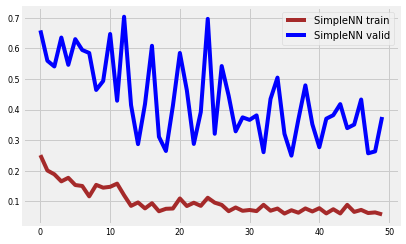

In [2037]:
plt.plot(h.history['loss'], label='SimpleNN train', color='brown')
plt.plot(h.history['val_loss'], label='SimpleNN valid', color='blue')
plt.legend()
plt.show()

In [2038]:
# plot actual and predicted value for N+1 period

Text(0.5, 0, 'date')

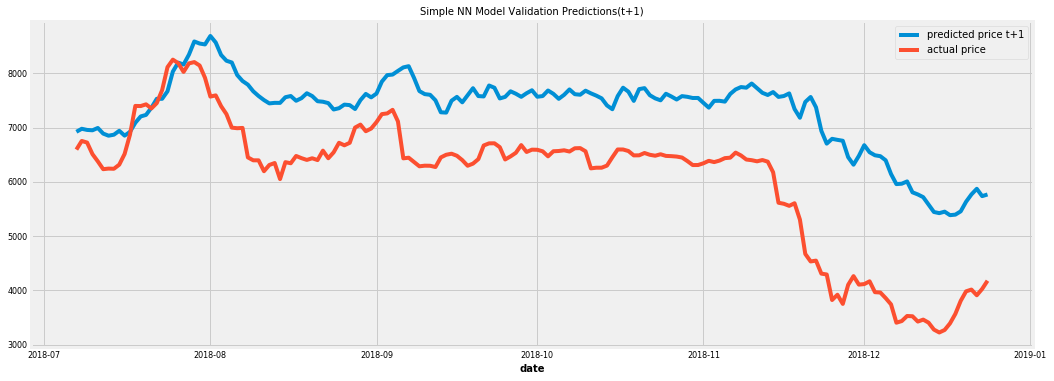

In [2039]:
unnormalised_y_valid_pred = y_normalizer.inverse_transform(y_valid_pred)
unnorm_y_valid = y_normalizer.inverse_transform(y_valid_leading)
plt.figure(figsize=(16,6))
plt.title('Simple NN Model Validation Predictions(t+1)')
sns.lineplot(y_valid_leading.index, unnormalised_y_valid_pred[:,0], label='predicted price t+1')
sns.lineplot(y_valid_leading.index, unnorm_y_valid[:, 0], label='actual price')
plt.xlabel('date')


score on validation set

In [2040]:
scores = simple_nn.evaluate(X_valid_lagged, y_valid_leading, verbose=0)
print("Accuracy: " + str(scores))

Accuracy: [0.37571840990356536, 0.30409356742574456]


In [2041]:
# saving normalizer 
from sklearn.externals import joblib 

In [2042]:
joblib.dump(y_normalizer, 'price_normalizer.pkl') 

['price_normalizer.pkl']

In [2043]:
#saving deep learning model

In [2044]:
joblib.dump(simple_nn, 'simple_nn.pkl') 

['simple_nn.pkl']

In [2045]:
X_train_lagged.to_csv('X_train_lagged.csv')
y_train_leading.to_csv('y_train_leading.csv')

X_valid_lagged.to_csv('X_valid_lagged.csv')
y_valid_leading.to_csv('y_valid_leading.csv')

X_test_lagged.to_csv('X_test_lagged.csv')
y_test_leading.to_csv('y_test_leading.csv')